<a href="https://colab.research.google.com/github/Dinesh9928/Pneumonia_detection/blob/main/Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jul 28 09:17:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2021-07-28 09:23:03--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-07-28 09:23:03--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2247b41fb2250578a569a485af.dl.dropboxusercontent.com/cd/0/inline/BTIgduGUTC73Ez8TrO_7--GUJ_jodGvPOYX3cNicUBhswuHaHRUZf3DSZ9gtnLB-MgWjVMYXdbtKFe_r9e4uoYLR3iL3ANMOhXKm_O3xifC1eLlsMaTeIVP-KpDduY4D8AH-V85C5q6kthxxLErCaTZ-/file# [following]
--2021-07-28 09:23:04--  https://uc2247b41fb2250578a569a485af.dl.dropboxusercontent.com/cd/0/inline/BTIgduGUTC73Ez8TrO_7--GUJ_jodGvPOYX3cNicUBhswuHaHRUZf3DSZ9gtnLB-MgWjVMYXdbtKFe_r9e4uoYLR3i

In [ ]:
# Unzipping the data
!unzip -q "archive.zip"

In [ ]:
# import required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [ ]:
# creating the pathlib PATH objects 
train_path = Path("chest_xray/train/")
validation_path=Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [ ]:
# collecting all paths inside "NORMAL" and "Pneumonia" folders of the above Paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator Object
print(train_image_paths)

<generator object Path.glob at 0x7fb47f0758d0>


In [ ]:
# Convert Generator object to List of Elements
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "Posixpath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/PNEUMONIA/person340_bacteria_1575.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person24_bacteria_111.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1049_bacteria_2983.jpeg')]


In [ ]:
# converting Posixpath to normal Strings
train_image_paths = list(map(lambda x: str(x), train_image_paths))
val_image_paths = list(map(lambda x : str(x), val_image_paths))

print(train_image_paths[:3])

['chest_xray/train/PNEUMONIA/person340_bacteria_1575.jpeg', 'chest_xray/train/PNEUMONIA/person24_bacteria_111.jpeg', 'chest_xray/train/PNEUMONIA/person1049_bacteria_2983.jpeg']


In [ ]:
# collecting Lenght for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [ ]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[1, 1, 1]


In [ ]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 127 ms, sys: 6.74 ms, total: 134 ms
Wall time: 257 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


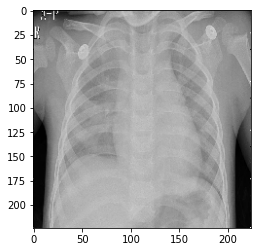

In [ ]:
# veiw a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [ ]:
%time val_dataset = get_dataset(val_image_paths, val_labels, train = False)
image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 21 ms, sys: 0 ns, total: 21 ms
Wall time: 24.6 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


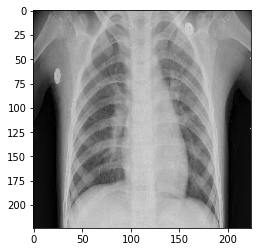

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False
)
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
# compling model by providing the optimier, Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss= 'binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Define callbacks
checkpoit = tf.keras.callbacks.ModelCheckpoint("best_weights_h5", verbose=1,save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
# training the model
history = model.fit(
    train_dataset, 
    steps_per_epoch=train_dataset_length/BATCH_SIZE,
    epochs=8, 
    callbacks=[checkpoit, early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - 200s 935ms/step - loss: 0.1675 - accuracy: 0.9433 - precision: 0.9607 - recall: 0.9694 - val_loss: 16.2576 - val_accuracy: 0.6365 - val_precision: 0.6365 - val_recall: 1.0000

Epoch 00001: val_loss improved from inf to 16.25755, saving model to best_weights_h5
Epoch 2/8
163/163 [==============================] - 152s 932ms/step - loss: 0.1180 - accuracy: 0.9597 - precision: 0.9739 - recall: 0.9718 - val_loss: 2.5125 - val_accuracy: 0.6184 - val_precision: 0.6140 - val_recall: 1.0000

Epoch 00002: val_loss improved from 16.25755 to 2.51246, saving model to best_weights_h5
Epoch 3/8
163/163 [==============================] - 152s 934ms/step - loss: 0.0888 - accuracy: 0.9684 - precision: 0.9788 - recall: 0.9790 - val_loss: 2.9332 - val_accuracy: 0.6694 - val_precision: 0.6694 - val_recall: 1.0000

Epoch 00003: val_loss did not improve from 2.51246
Epoch 4/8
163/163 [==============================] - 152s 935ms/step - loss: 0.0916 - accu

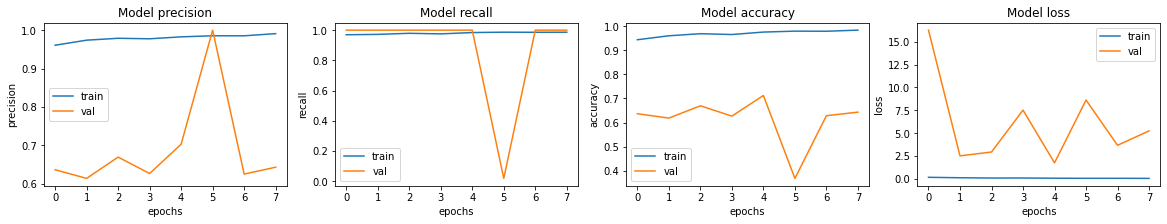

In [ ]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights_h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

In [ ]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [ ]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


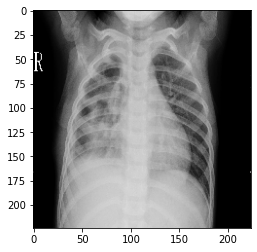

In [ ]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [ ]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 2s 2s/step - loss: 2.0926 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000
 Testing Acc :  0.5625
 Testing Precision  0.5333333611488342
 Testing Recall  1.0
